<a href="https://colab.research.google.com/github/MrPr3ntice/da_examples/blob/main/da_example_pca_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [ ]:
from matplotlib import pyplot as plt
import matplotlib
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import numpy as np

# for better reproducibility
np.random.seed(2022)

# Helper functions

In [ ]:
# define plotting function
def plot_datasets(dataset_list, n=1500, ax=None, names=None):
  if ax is None:
    ax = plt.gca()
  markers = ['o', 's', '+', 'v', 'x', '8']
  for i, data in enumerate(dataset_list):
    x, y = data
    labels_unique, labels_for_c = np.unique(y, return_inverse=True)
    cmap = plt.cm.rainbow
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=len(labels_unique)-1)
    if i == 2:
      alpha = 1
    else:
      alpha = 0.4
    for j, lab in enumerate(labels_unique):
      x_j = x[labels_for_c == j, :]
      n_j = min(n, x_j.shape[0])
      if names is None:
        name_i = str(i)
      else:
        name_i = names[i]
      ax.scatter(x_j[:n_j, 0],
                 x_j[:n_j, 1],
                 label='dataset: ' + name_i + ', class: ' + str(lab),
                 cmap='jet',
                 marker=markers[np.mod(i, len(markers))],
                 edgecolor=(0,0,0,1),
                 color=cmap(norm(lab)),
                 s=100,
                 alpha=alpha)
  ax.legend()
  ax.grid(True)
  ax.axis('equal')

# defining dataset function
def get_example_dataset(c_classes=2, n_s=500, n_t=100, class_sep=1.0):
  X, y_s = make_classification(
      n_samples=n_s,
      n_features=2,
      n_informative=2,
      n_redundant=0,
      n_repeated=0,
      n_classes=c_classes,
      n_clusters_per_class=1,
      weights=None,
      flip_y=0.0,
      class_sep=class_sep,
      hypercube=True,
      shift=0.0,
      scale=1.0,
      shuffle=True,
      random_state=None
  )
  X_s = X + np.random.normal(-6, 1, 2)
  # create 2nd dataset
  # random rotation
  theta = np.sign(np.random.rand()-0.5) * np.random.normal(0.5, 0.05) * np.pi
  rotMatrix = np.array([[np.cos(theta), -np.sin(theta)], 
                        [np.sin(theta),  np.cos(theta)]])
  X_t = X[:n_t, :]
  X_t = np.dot(((X_t + np.random.normal(0, 0.1, X_t.shape)) * np.random.normal(1.5,0.3)),
               rotMatrix) \
    + np.random.normal(6,1,2)
  y_t = y_s[:n_t]
  return X_s, y_s, X_t, y_t

# Generate random data for source and target domain

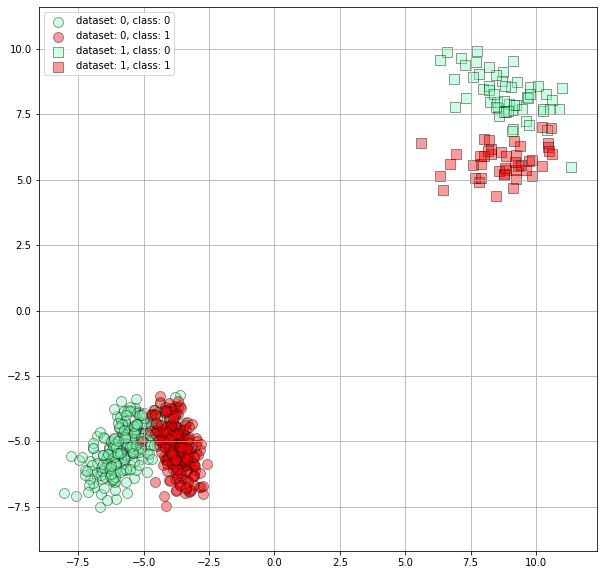

In [ ]:
# generate two datasets considering some (weak) assumptions
X_s, y_s, X_t, y_t = get_example_dataset(c_classes=2, n_s=500, n_t=100)

fig, ax = plt.subplots(figsize=(10, 10))
plot_datasets([(X_s, y_s), (X_t, y_t)], ax=ax)

# Try classification without alignment

In [ ]:
# define scoring function
def my_scorer(est, X_s, y_s, X_t, y_t):
  # randomly split first dataset
  X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(
      X_s, y_s, test_size=0.50, stratify=y_s
  )
  est.fit(X_s_train, y_s_train)
  print('Train ACC (on source domain): ', est.score(X_s_train, y_s_train))
  print('Test ACC (on source domain): ', est.score(X_s_test, y_s_test))
  # DA
  print('Test ACC (on target domain): ', est.score(X_t, y_t))
  print('Base rate ACC:', DummyClassifier(strategy='most_frequent').fit(X_s_train, y_s_train).score(X_t, y_t))

# perform classification with simple RBF-SVM
my_scorer(SVC(), X_s, y_s, X_t, y_t)

Train ACC (on source domain):  0.956
Test ACC (on source domain):  0.952
Test ACC (on target domain):  0.55
Base rate ACC: 0.55


# Is feature normalization a sufficient DA method?

In [ ]:
steps = [('normalizer', Normalizer()), ('svc', SVC())]
pipe = Pipeline(steps=steps)
pipe.steps[0][1].transform = lambda x: StandardScaler().fit_transform(x)  # hack to get (normally unprovided) feature normalizer
my_scorer(pipe, X_s, y_s, X_t, y_t)

Train ACC (on source domain):  0.964
Test ACC (on source domain):  0.956
Test ACC (on target domain):  0.51
Base rate ACC: 0.55


# Alignment: Step by step

Text(0.5, 1.0, 'shifted target')

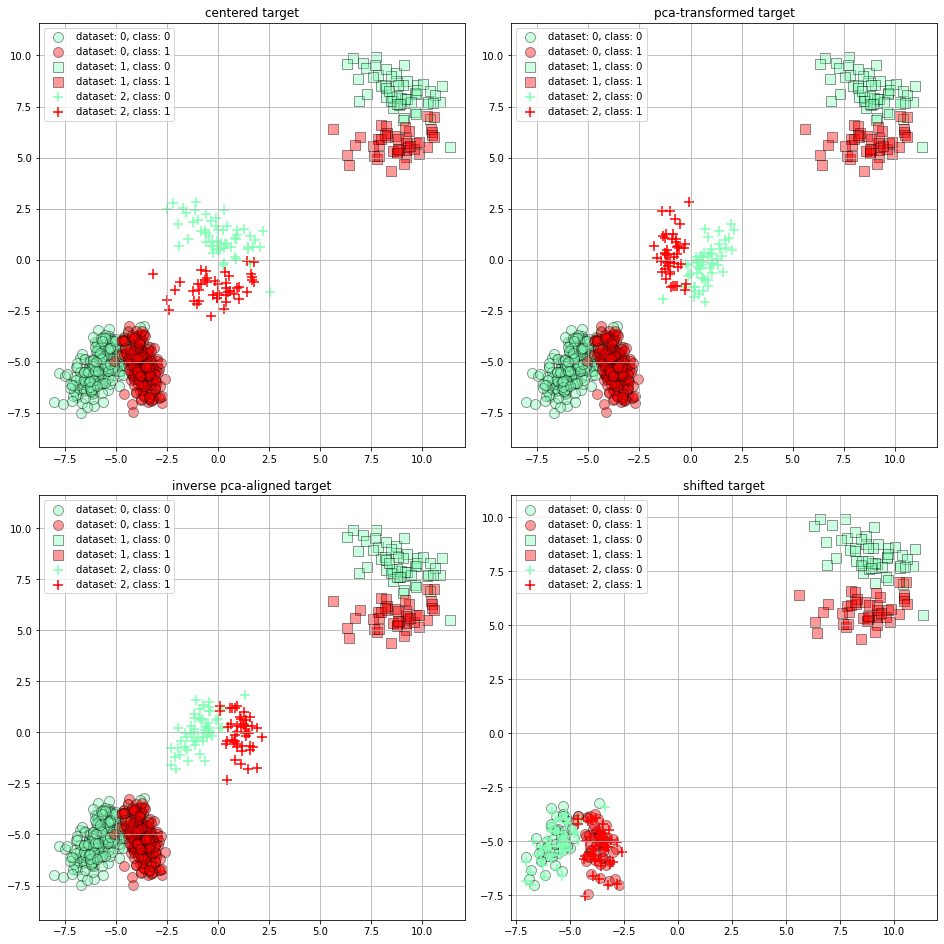

In [ ]:
# sub-space alignment using PCA
# get two PCA transformer
pca_s = PCA(copy=True, whiten=True, svd_solver='auto')
pca_t = clone(pca_s)

# calculate step by step
X_s_mean = np.mean(X_s, axis=0)  # redundant as PCA parameter whiten=True, but for better understanding...
X_t_mean = np.mean(X_t, axis=0)  # s.o.
pca_s.fit(X_s - X_s_mean)
pca_t.fit(X_t - X_t_mean)
X_t_centered = X_t - X_t_mean
X_t_whitened = pca_t.transform(X_t_centered)
X_t_whitened_rot = pca_s.inverse_transform(X_t_whitened)
X_t_aligned = X_t_whitened_rot + X_s_mean

# plot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(13, 13),
                        constrained_layout=True)
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_centered, y_t)], ax=axs[0, 0])
axs[0, 0].set_title('centered target')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_whitened, y_t)], ax=axs[0, 1])
axs[0, 1].set_title('pca-transformed target')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_whitened_rot, y_t)], ax=axs[1, 0])
axs[1, 0].set_title('inverse pca-aligned target')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_aligned, y_t)], n=50, ax=axs[1, 1])
axs[1, 1].set_title('shifted target')

# Alternative Approach
(Look here if you are a fan of pure lin. alg. :p)

Text(0.5, 1.0, 'shifted target')

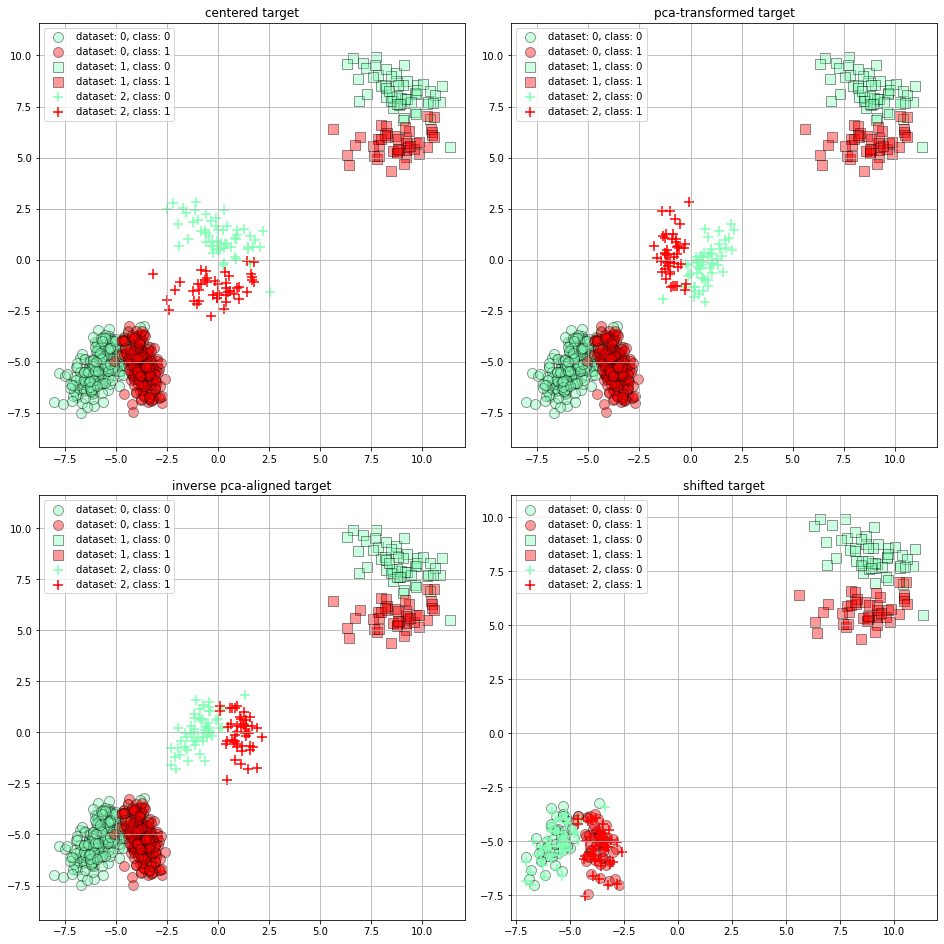

In [ ]:
# alternative, more mathematical approach. NOT READY YET!!
X_t_centered = X_t - np.mean(X_t, axis=0)   # centering
cov_t = np.cov(X_t_centered, rowvar=False)  # est. cov. mat.
eval_t, evec_t = np.linalg.eigh(cov_t)      # eigenvalue decomp.
idx_t = np.argsort(eval_t)[::-1]            # sort evec and eval by eval in desc. order
evec_t = evec_t[:, idx_t]
eval_t_mat = np.diag(1/np.sqrt(eval_t[idx_t]))
evec_t_norm = np.dot(evec_t, eval_t_mat) 
X_t_whitened = np.dot(X_t_centered, evec_t_norm)

X_s_centered = X_s - np.mean(X_s, axis=0)   # centering
cov_s = np.cov(X_s_centered, rowvar=False)  # est. cov. mat.
eval_s, evec_s = np.linalg.eigh(cov_s)      # eigenvalue decomp.
idx_s = np.argsort(eval_s)[::-1]            # sort evec and eval by eval in desc. order
evec_s = evec_s[:, idx_s]
eval_s_mat = np.diag(1/np.sqrt(eval_s[idx_s]))
evec_s_norm = np.dot(evec_s, eval_s_mat)
X_t_whitened_rot = np.dot(X_t_whitened, np.linalg.inv(evec_s_norm))

X_t_aligned = X_t_whitened_rot + np.mean(X_s, axis=0)

# plot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(13, 13),
                        constrained_layout=True)
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_centered, y_t)], ax=axs[0, 0])
axs[0, 0].set_title('centered target')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_whitened, y_t)], ax=axs[0, 1])
axs[0, 1].set_title('pca-transformed target')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_whitened_rot, y_t)], ax=axs[1, 0])
axs[1, 0].set_title('inverse pca-aligned target')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_t_aligned, y_t)], n=50, ax=axs[1, 1])
axs[1, 1].set_title('shifted target')

# Define PCA-alignement function

In [ ]:
# all in one function
def pca_align(X_s, X_t_train, X_t_test=None):
  if X_t_test is None:
    X_t_test = X_t_train
  pca_t = PCA(copy=True, whiten=True).fit(X_t_train)
  pca_s = PCA(copy=True, whiten=True).fit(X_s)
  X_t_test_whitened = pca_t.transform(X_t_test)
  return pca_s.inverse_transform(X_t_test_whitened)

# Test everything again with new data

Train ACC (on source domain):  0.996
Test ACC (on source domain):  0.996
Test ACC (on target domain):  0.33
Base rate ACC: 0.5


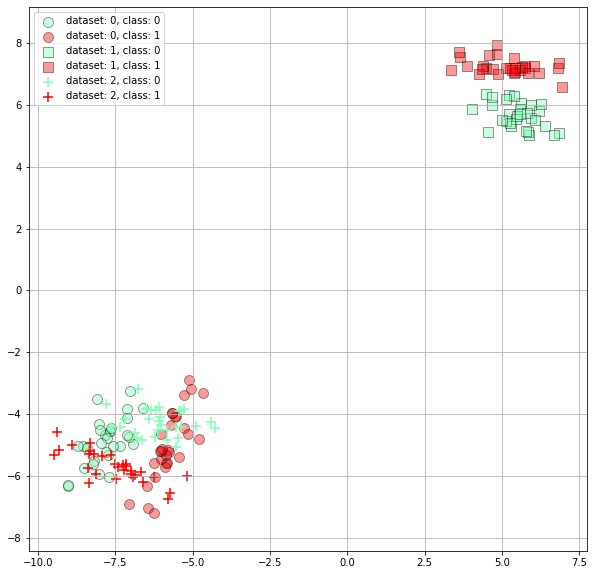

In [ ]:
# try alignment with new data
X_s, y_s, X_t, y_t = get_example_dataset(c_classes=2, n_s=500, n_t=100)
fig, ax = plt.subplots(figsize=(10, 10))
X_s_aligned = pca_align(X_s, X_t)
plot_datasets([(X_s, y_s), (X_t, y_t), (X_s_aligned, y_t)], n=30, ax=ax)
my_scorer(SVC(), X_s, y_s, X_s_aligned, y_t)

# Limitations?
PCA is blind for the target value (e.g. class information), not only in the target's case (i.e. the standard *unsupervised domain adaptation*) but also for the source data. More precise, PCA-alignment $f_{\text{PCA}}(̇X_t|X_s)$ does an acceptable job by aligning the marginal distributions $P(X_s)\approx P(f_{\text{PCA}}(X_t))$, but when you try to align also the conditional distributions $P(y_s|X_s)$ and $P(y_t|X_t)$ it generally fails:

Train ACC (on source domain):  0.824
Test ACC (on source domain):  0.844
Test ACC (on target domain):  0.17
Base rate ACC: 0.26


Text(0.5, 1.0, 'pca-transformed target')

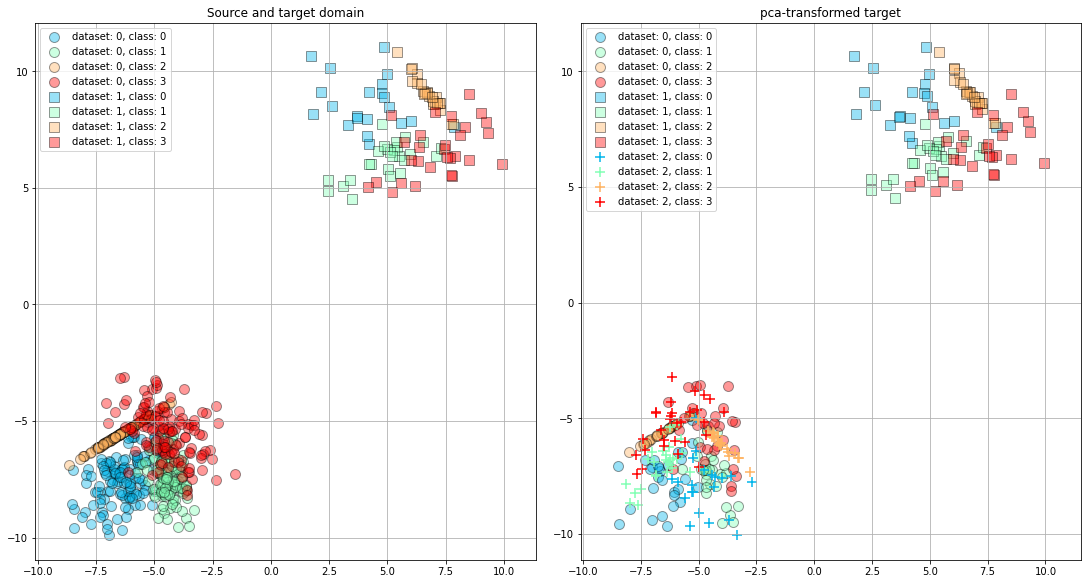

In [ ]:
# try alignment with new data
X_s, y_s, X_t, y_t = get_example_dataset(c_classes=4, n_s=500, n_t=100)
X_s_aligned = pca_align(X_s, X_t)

my_scorer(SVC(), X_s, y_s, X_s_aligned, y_t)
# plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 8),
                        constrained_layout=True)
plot_datasets([(X_s, y_s), (X_t, y_t)], ax=axs[0])
axs[0].set_title('Source and target domain')
plot_datasets([(X_s, y_s), (X_t, y_t), (X_s_aligned, y_t)], n=30, ax=axs[1])
axs[1].set_title('pca-transformed target')